> a) Visualice los datos ¿Qué es la entrada y qué es la salida? Comente sobre los múltiples significados/sinónimos que puede tener una palabra al ser traducida y cómo propondría arreglar eso. *se espera que pueda implementarlo*

Vamos a partir trabajando con una sistema de traducción ingles-frances, el primer paso como siempre es cargar los datos y hacer un análisis de estos.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding,CuDNNGRU
from keras.layers import RepeatVector
from keras.layers import CuDNNGRU, TimeDistributed,Dense

Using TensorFlow backend.


In [0]:
import collections
#import helper
import numpy as np
#import project_tests as tests
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

In [3]:


%matplotlib inline


df = pd.read_csv("fra.txt", sep="\t", names=["Source","Target"])
df.head()

,Source,Target
0,Go.,Va !
1,Hi.,Salut !
2,Run!,Cours !
3,Run!,Courez !
4,Who?,Qui ?


La entrada (Source) en este caso son frases en ingles, las primeras que se ven son frases de una sola palabra. La salida (Target) es su traducción al frances, no es una traducción literal, en su lugar se trata de la interpretación o simil de la frase en frances.

In [4]:
df[17:19]

,Source,Target
17,Hello!,Bonjour !
18,Hello!,Salut !


In [5]:
df.describe

<bound method NDFrame.describe of                                                    Source                                             Target
0                                                     Go.                                               Va !
1                                                     Hi.                                            Salut !
2                                                    Run!                                            Cours !
3                                                    Run!                                           Courez !
4                                                    Who?                                              Qui ?
5                                                    Wow!                                         Ça alors !
6                                                   Fire!                                           Au feu !
7                                                   Help!                                     

In [6]:
df.count()

Source    167130
Target    167130
dtype: int64

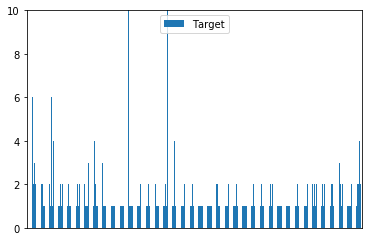

In [7]:
df[0:100000].groupby(['Source']).count().plot(kind='bar')
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
plt.ylim(0,10)
plt.show()

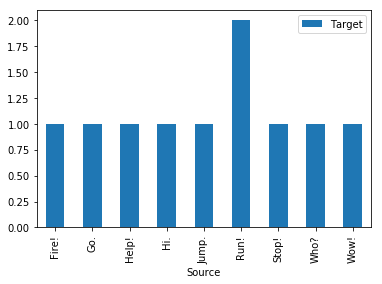

In [8]:
df[0:10].groupby(['Source']).count().plot(kind='bar')

Para hacer una limpieza de este tipo de casos se debería definir un criterio claro sobre intepretaciones, por ejemplo Bonjour es buenos días y Salut es saludos, es esta forma sería mejor que se usase good morning y hello respectivamente. Se necesita un contexto para poder traducir correctamente esta simple frase de una palabra.
La otra alternativa es simplemente elegir un representante por frase, quizas la raiz de todas las conjugaciónes.
Según los resultados de las redes neuronales se volverá a este punto para evaluar los efecto de los cambios hechos.
Alternativamente se pueden entregar más de una opción de traducción, por ejemplo la segunda y/o tercera traducción más probable.

El gráfico sirve para ver que la repetición de palabras en frances es más comun de lo que uno creería previamente, con conocimiento previo esto se puede corroborar ya que el frances diferencia más claramente cuando el sujeto es hombre o mujer. El ejemplo de Run sirve para ejemplificar eso, las dos acepciones se refieren a cuando es un hombre y cuando se trata de una mujer.

In [9]:
ingles_contadorr = collections.Counter([word for sentence in df['Source'] for word in sentence.split()])
frances_contador = collections.Counter([word for sentence in df['Target'] for word in sentence.split()])
print('{} Palabras en Ingles.'.format(len([word for sentence in df['Source'] for word in sentence.split()])))
print('{} Palabras únicas en Ingles.'.format(len(ingles_contadorr)))
print('10 Palabras más comunes del dataset de Ingles:')
print('"' + '" "'.join(list(zip(*ingles_contadorr.most_common(10)))[0]) + '"')
print()
print('{} Palabras en Frances.'.format(len([word for sentence in df['Target'] for word in sentence.split()])))
print('{} alabras únicas en Frances.'.format(len(frances_contador)))
print('10  Palabras más comunes del dataset de Frances:')
print('"' + '" "'.join(list(zip(*frances_contador.most_common(10)))[0]) + '"')

1028095 Palabras en Ingles.
26936 Palabras únicas en Ingles.
10 Palabras más comunes del dataset de Ingles:
"I" "to" "you" "the" "a" "is" "Tom" "of" "in" "He"

1118669 Palabras en Frances.
44228 alabras únicas en Frances.
10  Palabras más comunes del dataset de Frances:
"de" "Je" "?" "pas" "que" "à" "ne" "la" "le" "Il"


> b) Realice un pre-procesamiento a los textos como se acostumbra para eliminar símbolos inecesarios u otras cosas que estime conveniente, comente sobre la importancia de éste paso. Además de ésto deberá agregar un símbolo al final de la sentencia *target* para indicar un "alto" cuando la red neuronal necesite aprender a generar una sentencia.

In [0]:
import string
table = str.maketrans('', '', string.punctuation) 
def clean_text(text, where=None):
    """ OJO: Sin eliminar el significado de las palabras."""
    text = text.lower()
    tokenize_text = text.split()
    tokenize_text = [word.translate(table) for word in tokenize_text]#eliminar puntuacion
    tokenize_text = [word for word in tokenize_text if word.isalpha()] #remove numbers
    if where =="target":
        tokenize_text = tokenize_text + ["#end"] 
    return tokenize_text
texts_input = list(df['Source'].apply(clean_text))
texts_output = list(df['Target'].apply(clean_text, where='target'))

La primera parte, table, generea un mapeo de diccionario de cada caracter en string punctuation a nada. El resto queda bastante claro.

Este paso e simportante pues nos entrega un formato más comprensible para la maquina, se trata de una lista ordenada de strings, la abstracción del lenguaje no es total ya que las palabras siguen teniendo tiempos verbales lo que es importante para traducir textos y entender su contexto, pero por otro lado los numero se pueden traducir textualmente, y con la puntuación se puede hacer algo similiar, con mayor o menor efectividad dependiendo del tipo, los signos de exclamación y pregunta mantienen su ubicación sin mayor drama, pero las comas no tienen un análogo tan directo.
Se mantuvo la señal "#end" para marcar el final de las frase en la nueva lista de 'Target'. No hay razón para cambiarla, ya que no se van a encontrar palabras en frances que usen # ni end. 


In [11]:
texts_output

[['va', '#end'],
 ['salut', '#end'],
 ['cours', '#end'],
 ['courez', '#end'],
 ['qui', '#end'],
 ['ça', 'alors', '#end'],
 ['au', 'feu', '#end'],
 ['à', 'laide', '#end'],
 ['saute', '#end'],
 ['ça', 'suffit', '#end'],
 ['stop', '#end'],
 ['arrêtetoi', '#end'],
 ['attends', '#end'],
 ['attendez', '#end'],
 ['poursuis', '#end'],
 ['continuez', '#end'],
 ['poursuivez', '#end'],
 ['bonjour', '#end'],
 ['salut', '#end'],
 ['je', 'comprends', '#end'],
 ['jessaye', '#end'],
 ['jai', 'gagné', '#end'],
 ['je', 'lai', 'emporté', '#end'],
 ['gagné', '#end'],
 ['oh', 'non', '#end'],
 ['attaque', '#end'],
 ['attaquez', '#end'],
 ['santé', '#end'],
 ['à', 'votre', 'santé', '#end'],
 ['merci', '#end'],
 ['tchintchin', '#end'],
 ['lèvetoi', '#end'],
 ['va', 'maintenant', '#end'],
 ['allezy', 'maintenant', '#end'],
 ['vasy', 'maintenant', '#end'],
 ['jai', 'pigé', '#end'],
 ['compris', '#end'],
 ['pigé', '#end'],
 ['compris', '#end'],
 ['tas', 'capté', '#end'],
 ['monte', '#end'],
 ['montez', '#end'],


> Cree un conjunto de validación y de pruebas fijos de $N_{exp} = 10000$ datos ¿Cuántos datos quedan para entrenar? 


In [0]:
from sklearn.model_selection import train_test_split

In [0]:
N_exp= 10000


X_train_l, X_test_l, Y_train_l, Y_test_l = train_test_split(texts_input, texts_output,
                                                            test_size=N_exp, random_state=22)
X_train_l, X_val_l, Y_train_l, Y_val_l = train_test_split(X_train_l, Y_train_l, 
                                                          test_size=N_exp, random_state=22)

In [14]:
X_test_l[1]

['he', 'gave', 'me', 'a', 'ride', 'home']

In [15]:
Y_test_l[1]

['il', 'ma', 'raccompagnée', 'chez', 'moi', 'en', 'voiture', '#end']

In [16]:
len(X_test_l)

10000

In [17]:
len(X_val_l)

10000

In [18]:
len(X_train_l)

147130

> c) Genere un vocabulario, **desde el conjunto de entrenamiento**, sobre las palabras a recibir y generar en la traducción, esto es codificarlas a un valor entero que servirá para que la red las vea en una representación útil a procesar, *comience desde el 1 debido a que el cero será utilizado más adelante*. Para reducir el vocabulario considere las palabras que aparecen un mínimo de *min_count* veces en todo los datos, se aconseja un valor de 3. Comente sobre la importancia de ésto al reducir el vocabulario ¿De qué tamaño es el vocabulario de entrada y salida? ¿La diferencia de ésto podría ser un factor importante?

In [0]:
def create_vocab(texts, min_count=1):
    count_vocab = {}
    for sentence in texts:
        for word in sentence:
            if word not in count_vocab:
                count_vocab[word] = 1
            else:
                count_vocab[word] += 1
    return [word for word,count in count_vocab.items() if count >= min_count]


In [0]:
vocab_source = create_vocab(X_train_l, min_count=3)
word2idx_s = {w: i+1 for i, w in enumerate(vocab_source)} #index (i+1) start from 1,2,3,...
idx2word_s = {i+1: w for i, w in enumerate(vocab_source)}
n_words_s = len(vocab_source)
vocab_target = create_vocab(Y_train_l, min_count=3)
word2idx_t = {w: i+1 for i, w in enumerate(vocab_target)}  #Converting text to numbers
idx2word_t = {i+1: w for i, w in enumerate(vocab_target)}  #Converting number to text
n_words_t = len(vocab_target)

In [21]:
print('El vocabulario  de entrenamiento de Ingles (source) tiene un largo' ,  n_words_s, 'palabras')
print('El vocabulario  de entrenamiento de Frances (target) tiene un largo' ,  n_words_t, 'palabras')
print('Hay una diferencia de', n_words_s-n_words_t, 'entre los dos conjuntos')

El vocabulario  de entrenamiento de Ingles (source) tiene un largo 7339 palabras
El vocabulario  de entrenamiento de Frances (target) tiene un largo 12338 palabras
Hay una diferencia de -4999 entre los dos conjuntos


Existe una diferencia clara entre el vocabulario de entrada y de salida, es lógico que esto pase ya que ambas lenguas tienen orgines lexicos distintos. Esto no necesariamente va a perjudicar al estudio, ya que no todas las palabras tienen como traducción solo una palabra y hay casos en que dos palabras pueden ser traducciones válidas dependiendo del contexto.  
Como anotación para el 'Source' el vocabulario se reduce en 5000 palabras aproximadamente, pero en el 'Target' se ignora la mitad.

Ignorar ciertas palabras poco comúnes, como en español xilofono, ayuda a evitar el overfitting o que se aprendan características de poco valor para el modelo, pero si se ignoran muchas palabras también caemos en ofecfittig.



>Ahora codifique las palabras a los números indexados con el vocabulario. Recuerde que si una palabra en los otros conjuntos, o en el mismo de entrenamiento, no aparece en el vocabulario no se podrá generar una codificación, por lo que será **ignorada** ¿Cómo se podría evitar ésto?

En estos casos se podría manejar un diccionario de traducción inmediata, que entregue un resultado predeterminado dependiendo de la palabra del source o target que fue ignorada en los conjuntos de entrenamiento. Esto reduciría la precisión pero al menos permitiría que toda la frase fuera reescrita en el idioma de llegada, con un mayor o menor grado de precisión.

Otra alternativa es hacer una doble limpieza de las frases en el source y en target que contengan estas palabras poco comunes, pero esto puede reducir en sobremanera el dataset.

In [0]:
#""" Source/input data """
dataX_train = [[word2idx_s[word] for word in sent if word in word2idx_s] for sent in X_train_l]
dataX_valid = [[word2idx_s[word] for word in sent if word in word2idx_s] for sent in X_val_l]
dataX_test = [[word2idx_s[word] for word in sent if word in word2idx_s] for sent in X_test_l]


#""" Target/output data """
dataY_train = [[word2idx_t[word] for word in sent if word in word2idx_t] for sent in Y_train_l]
dataY_valid = [[word2idx_t[word] for word in sent if word in word2idx_t] for sent in Y_val_l] 
dataY_test = [[word2idx_t[word] for word in sent if word in word2idx_t] for sent in Y_test_l] 



In [23]:
dataX_train[0:8]

[[1, 2, 3, 4, 5, 6],
 [7, 8, 5, 9],
 [10, 8, 11, 12, 13],
 [1, 14, 15, 1, 16, 3],
 [17, 18, 19],
 [10, 20, 21, 22],
 [1, 23, 24, 25, 26, 27, 28, 29, 30],
 [1, 31, 32, 27, 33, 34]]

> d) Debido al largo variable de los textos de entrada y salida será necesario estandarizar ésto para poder trabajar de manera más cómoda en Keras, *cada texto (entrada y salida) pueden tener distinto largo máximo*. Comente sobre la decisión del tipo de *padding*, *pre o post* ¿Qué sucede al variar el largo máximo de instantes de tiempo para procesar en cada parte del modelo (entrada y salida)?

Hasta no probar las dos alternativas, a priorí no sabemos como afectará al aprendizaje del modelo. Sin embargo, buscando sobre el tema, encontramos que se recomienda que el input tenga pre padding y el output tenga postpadding, ya que supuestamente que las "palabras" estén juntas es mejor para el desempeño del modelo.




¿Qué sucede al variar el largo máximo de instantes de tiempo para procesar en cada parte del modelo (entrada y salida)? : 
>| El modelo encoder decoder se va a encargar de que se adapten los largos acorde al idioma en el que se esta trabajando para que todo tome sentido.

In [24]:
from keras.preprocessing import sequence

print('Dato preprocesados')

""" INPUT DATA (Origin language) """
max_inp_length = max(map(len,dataX_train))
print("Largo max Source(Ingles): ",max_inp_length)
word2idx_s["*"] = 0 #padding symbol
idx2word_s[0] = "*"
n_words_s += 1  


X_train = sequence.pad_sequences(dataX_train, maxlen=max_inp_length, padding='pre', value=word2idx_s["*"])
X_valid = sequence.pad_sequences(dataX_valid, maxlen=max_inp_length, padding='pre', value=word2idx_s["*"])
X_test = sequence.pad_sequences(dataX_test, maxlen=max_inp_length, padding='pre', value=word2idx_s["*"])


""" OUTPUT DATA (Destination language) """
max_out_length = max(map(len,dataY_train)) 
print("Largo max Target(Fances): ",max_out_length)
word2idx_t["*"] = 0 #padding symbol
idx2word_t[0] = "*"
n_words_t += 1  

Y_train = sequence.pad_sequences(dataY_train, maxlen=max_out_length, padding='post', value=word2idx_t["*"])
Y_valid = sequence.pad_sequences(dataY_valid, maxlen=max_out_length, padding='post', value=word2idx_t["*"])
Y_test = sequence.pad_sequences(dataY_test, maxlen=max_out_length, padding='post', value=word2idx_t["*"])


print('El vocabulario  de entrenamiento de Ingles (source) tiene un largo' ,  n_words_s, 'palabras')
print('El vocabulario  de entrenamiento de Frances (target) tiene un largo' ,  n_words_t, 'palabras')
print('Hay una diferencia de', n_words_s-n_words_t, 'entre los dos conjuntos')



Dato preprocesados
Largo max Source(Ingles):  44
Largo max Target(Fances):  54
El vocabulario  de entrenamiento de Ingles (source) tiene un largo 7340 palabras
El vocabulario  de entrenamiento de Frances (target) tiene un largo 12339 palabras
Hay una diferencia de -4999 entre los dos conjuntos


max inp length y max out length se usaran despues para definir un largo estandar de las frases, en ambos idiomas, para el encoder decorder, con esto se pueden conectar capas densas y planas ("flatten"). 
Se aumenta la dimensionalidad de los Y, para que sea compatible con la dimensión de la capa TimeDistributed que se usará en el modelo.


In [25]:
X_test[0:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   31,   91,   11,  617,   27,  534],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   10, 1320,  204,   11, 1356,   81],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   55,  131,  291,   74,  537,  129],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    

In [26]:
Y_test[0:5]

array([[  41,  590,  394,  102,   81,   10,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  29,  232,   96,  264,    8,  141,   10,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  71, 2259,    3,  328,   62, 1504,   57,   97,   10,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0

> e) Para evitar que la red obtenga una ganancia por imitar/predecir el símbolo de *padding* que está bastante presente en los datos coloque un peso sobre éste clase, con valor 0, así se evita que tenga impacto en la función objetivo. Ya que *keras* no soporta directamente ésto en series de tiempo coloque el peso a cada instante de tiempo de cada dato de entrenamiento dependiendo de su clase. Comente sobre alguna otra forma en que se podría manejar el evitar que la red prediga en mayoría el símbolo de *padding*.

In [0]:
c_weights = np.ones(n_words_t)
c_weights[0] = 0 #padding class masked
sample_weight = np.zeros(Y_train.shape)
for i in range(sample_weight.shape[0]):
    sample_weight[i] = c_weights[Y_train[i,:]]
    
    


Primero c_weights genera un arreglo de ceros del largo de las palabras en el target, se le da peso 0 a la primera palabra, que justamente es el padding que utilizamos y reservamos anteriormente.
sample_weight, genera una matriz de pesoso para cada palabra en el entrenamiento, se estandarizan los pesos de todas las palabras como 0.
Es una matriz de pesoso para el conjunto Y de entrenamiento.

> f) Para lograr la tarea defina una red recurrente del tipo *encoder*-*decoder* como la que se presenta en la siguiente imágen.
<img src="https://chunml.github.io/ChunML.github.io/images/projects/sequence-to-sequence/repeated_vector.png" width="60%" />
En primer lugar defina el *Encoder* que procesara el texto de entrada y retornará un solo vector final, haciendo uso de las capas ya conocidas de *Embedding* para generar un vector denso de palabra y *GRU*, pero en su versión acelerada para GPU.

Luego defina la sección que conecta el largo (*timesteps*) de entrada *vs* el de salida.

Finalmente defina el *Decoder* para generar la secuencia de salida en texto de palabras en otro idioma, a través de la función *softmax* sobre cada instante de tiempo (*timestep*. 

Entrene la red entre 1 a 5 *epochs*, agregando los pesos definidos sobre cada ejemplo de entrenamiento. Además de utilizar una función de pérdida que evita generar explícitamente los *one hot vector*

In [28]:
max_inp_length

44

In [29]:
n_words_s

7340

Se crea el Encoder que recive como entrada el vector del diccionario de ingles, y sale un vector de dimención 100 denso que cambia la representación de las oraciones.
Las capas de CuDNNGRU, son GRU rapidas (gate recurrent unit)
La última capa retorna solo el el último output de la secuencia.
Este encoder sirve para darle un contexto al vocabulario del diccionario en ingles, que palabras tienden a ir juntar y en que orden, etc.

El Vector repetidor, simplemente repite el vector que recive para que tenga la misma dimensión que las frases en frances (max_out_length)

El decoder funciona de manera similar, pero ambas capas CuDNNGRU entregan la lista de outputs, y es la capa final, timedistributed, la que hace una capa densa con el largo del diccionario de frances (target).

Se usa la función de perdida sparse_categorical_crossentropy, ya que con eso no tenemos que generar 'one-hot vector', y así evaluamos sobre los valores enteros de la salida.
Los 5 modelos probados tienen un desempeño similar considerando el val_loss

In [30]:
#from keras.layers import CuDNNGRU, TimeDistributed,Dense
EMBEDDING_DIM = 100
learning_rate = 1e-3
model = Sequential()
model.add(Embedding(input_dim=n_words_s, output_dim=EMBEDDING_DIM, input_length=max_inp_length))
model.add(CuDNNGRU(64, return_sequences=True))
model.add(CuDNNGRU(128, return_sequences=False))


model.add(RepeatVector(max_out_length)) #conection

model.add(CuDNNGRU(128, return_sequences=True))
model.add(CuDNNGRU(64, return_sequences=True))

model.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
model.summary()

W0805 17:43:05.535273 140170182502272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 17:43:05.576995 140170182502272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 17:43:05.585782 140170182502272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 44, 100)           734000    
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 44, 64)            31872     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 128)               74496     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 54, 128)           0         
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, 54, 128)           99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 54, 64)            37248     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 54, 12339)         802035    
Total para

In [31]:
Y_train.shape

(147130, 54)

In [0]:
Y_test=Y_test[:,:,None]
Y_valid=Y_valid[:,:,None]
Y_train=Y_train[:,:,None]

In [33]:
Y_train.shape

(147130, 54, 1)

In [0]:
from tensorflow.contrib.rnn import *

In [35]:
mejor_epoch = 0
mejor_desempeño=1000
for i in range(5):
  
  EMBEDDING_DIM = 100
  learning_rate = 1e-3
  model = Sequential()
  model.add(Embedding(input_dim=n_words_s, output_dim=EMBEDDING_DIM, input_length=max_inp_length))
  model.add(CuDNNGRU(64, return_sequences=True))
  model.add(CuDNNGRU(128, return_sequences=False))


  model.add(RepeatVector(max_out_length)) #conection

  model.add(CuDNNGRU(128, return_sequences=True))
  model.add(CuDNNGRU(64, return_sequences=True))

  model.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
  model.summary()
  
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')#, metrics = ['accuracy'])
  h = model.fit(X_train, Y_train, epochs=i+1, batch_size=256, verbose= 1, validation_data=(X_valid, Y_valid), sample_weight = sample_weight) 
  desempeño= h.history["val_loss"]
  if desempeño[-1] <mejor_desempeño:
    mejor_desempeño=desempeño[-1]
    mejor_epoch=i+1
  print('Para', i+1, 'epochs, el desempeño fue:', desempeño)
  

  
#    evaluate(x=X_train, y=Y_train, batch_size=256, verbose=1, sample_weight=sample_weight)


W0805 17:43:08.257223 140170182502272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0805 17:43:08.280075 140170182502272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3341: The name tf.log is deprecated. Please use tf.math.log instead.

W0805 17:43:08.385264 140170182502272 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 44, 100)           734000    
_________________________________________________________________
cu_dnngru_5 (CuDNNGRU)       (None, 44, 64)            31872     
_________________________________________________________________
cu_dnngru_6 (CuDNNGRU)       (None, 128)               74496     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 54, 128)           0         
_________________________________________________________________
cu_dnngru_7 (CuDNNGRU)       (None, 54, 128)           99072     
_________________________________________________________________
cu_dnngru_8 (CuDNNGRU)       (None, 54, 64)            37248     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 54, 12339)         802035    
Total para

W0805 17:43:08.856670 140170182502272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 147130 samples, validate on 10000 samples
Epoch 1/1
147130/147130 [==============================] - 123s 837us/step - loss: 6.2593 - val_loss: 13.6146
Para 1 epochs, el desempeño fue: [13.61455868988037]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 44, 100)           734000    
_________________________________________________________________
cu_dnngru_9 (CuDNNGRU)       (None, 44, 64)            31872     
_________________________________________________________________
cu_dnngru_10 (CuDNNGRU)      (None, 128)               74496     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 54, 128)           0         
_________________________________________________________________
cu_dnngru_11 (CuDNNGRU)      (None, 54, 128)           99072     
____________________________________________________________

In [37]:
  EMBEDDING_DIM = 100
  learning_rate = 1e-3
  model1 = Sequential()
  model1.add(Embedding(input_dim=n_words_s, output_dim=EMBEDDING_DIM, input_length=max_inp_length))
  model1.add(CuDNNGRU(64, return_sequences=True))
  model1.add(CuDNNGRU(128, return_sequences=False))


  model1.add(RepeatVector(max_out_length)) #conection

  model1.add(CuDNNGRU(128, return_sequences=True))
  model1.add(CuDNNGRU(64, return_sequences=True))

  model1.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
  model1.summary()
  
  model1.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')#, metrics = ['accuracy'])
  h = model1.fit(X_train, Y_train, epochs=5, batch_size=256, verbose= 1, validation_data=(X_valid, Y_valid), sample_weight = sample_weight) 
  desempeño= h.history["val_loss"]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 44, 100)           734000    
_________________________________________________________________
cu_dnngru_29 (CuDNNGRU)      (None, 44, 64)            31872     
_________________________________________________________________
cu_dnngru_30 (CuDNNGRU)      (None, 128)               74496     
_________________________________________________________________
repeat_vector_8 (RepeatVecto (None, 54, 128)           0         
_________________________________________________________________
cu_dnngru_31 (CuDNNGRU)      (None, 54, 128)           99072     
_________________________________________________________________
cu_dnngru_32 (CuDNNGRU)      (None, 54, 64)            37248     
_________________________________________________________________
time_distributed_8 (TimeDist (None, 54, 12339)         802035    
Total para

In [38]:
desempeño[-1]

14.012416613769531

el largo de los datos de entrada y salida, así como el tamañano del conjutno de entrenamiento afecta al tiempo.
Se podrían partir la frases más largas, ya que varias frases estan formadas por oraciones más pequeñas que son autocontenidad.

> g) Debido a lo costoso de tener una red completamente recurrente para entrenar y poder experimentar, cambie el modelo que procesa el *Encoder* por una red convolucional, reduciendo el número de capas pero aumentando las neuronas. Utilice tamaños de *kernel*  igual a 5 y funciones de activaciones relu. Se agregan capas de *BatchNormalization* debido a que en el *Decoder* contamos con redes recurrentes que tienen capa activación distinta a la usada por las convoluciones. La capa de *GlobalMaxPooling1d* es lo que permite reducir toda la información extraída a un único vector, como se realizó anteriormente con *return_sequences=False*, comente sobre la ganancia o desventaja de ésto *vs* la red neuronal.

Entrene el modelo igual a lo presentado anteriormente pero ahora por 20 *epochs* ¿Cambian los tiempos de procesamiento y la cantidad de parámetros?

In [40]:
from keras.layers import Conv1D,MaxPool1D,GlobalMaxPooling1D,GlobalAveragePooling1D,BatchNormalization
model2 = Sequential()
model2.add(Embedding(input_dim=n_words_s, output_dim=EMBEDDING_DIM, input_length=max_inp_length))
model2.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
model2.add(BatchNormalization()) #for stability
model2.add(Conv1D(256, 5, padding='same', activation='relu', strides=1))
model2.add(BatchNormalization())
model2.add(GlobalMaxPooling1D()) #aka to return_sequences=False
model2.add(RepeatVector(max_out_length)) #conection
model2.add(CuDNNGRU(256, return_sequences=True))
model2.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
model2.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 44, 100)           734000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 44, 256)           128256    
_________________________________________________________________
batch_normalization_3 (Batch (None, 44, 256)           1024      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 44, 256)           327936    
_________________________________________________________________
batch_normalization_4 (Batch (None, 44, 256)           1024      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
repeat_vector_10 (RepeatVect (None, 54, 256)           0         
__________

In [41]:
#optimizer = 'rmsprop'
  
model2.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')#, metrics = ['accuracy'])
h2=model2.fit(X_train, Y_train, epochs=20, batch_size=256,validation_data=(X_valid, Y_valid), sample_weight = sample_weight)
    

Train on 147130 samples, validate on 10000 samples
Epoch 1/20
147130/147130 [==============================] - 169s 1ms/step - loss: 4.9064 - val_loss: 14.4272
Epoch 2/20
147130/147130 [==============================] - 165s 1ms/step - loss: 3.8372 - val_loss: 14.4161
Epoch 3/20
147130/147130 [==============================] - 165s 1ms/step - loss: 3.3923 - val_loss: 14.3383
Epoch 4/20
147130/147130 [==============================] - 165s 1ms/step - loss: 3.1177 - val_loss: 14.2519
Epoch 5/20
147130/147130 [==============================] - 165s 1ms/step - loss: 2.9301 - val_loss: 14.3043
Epoch 6/20
147130/147130 [==============================] - 165s 1ms/step - loss: 2.7882 - val_loss: 14.1891
Epoch 7/20
147130/147130 [==============================] - 165s 1ms/step - loss: 2.6651 - val_loss: 14.2041
Epoch 8/20
147130/147130 [==============================] - 165s 1ms/step - loss: 2.5681 - val_loss: 14.3009
Epoch 9/20
147130/147130 [==============================] - 165s 1ms/step - l

Una diferencia obvia entre los dos modelos es la cantidad de parámetros que aparecen, el modelo1 tenía cerca de 1.700.000 parametros entrenables, sin haber ninguno no entrenable.
Pero el modelo 2 tiene casi el triple, aproximadamente 4.750.000 parametros entrenables, y 1024 no entrenables, que vienen de la capa de batch normalization.

Además el entrenamiento de los epoch dura más, y su desempeño no es mejor que le modelo original usado.
No solo eso, el desempeño con  solo dos epochs entrenados, es cercano al mejor desempeño logrado. Lo que nos hace creer que se llega a un overfitting, donde la loss sigue mejorando, pero la val_loss no, aunque en nuestro caso se mantiene estable.

> h) Visualice lo aprendido por el modelo sobre algunos datos del conjunto de entrenamiento y validación, comente lo observado.

In [0]:
def predict_words(y_indexs, data="target"):
    """ Predict until '-#end-' is seen """
    return_val = []
    for indx_word in y_indexs:
        if indx_word != 0: #start to predict
            return_val.append(np.squeeze(indx_word))
            if data == "target": #if target is predicting
                if indx_word == word2idx_t["#end"]:
                    return return_val                
    return return_val


In [43]:
n_s = 50

X_set=X_train
Y_set=Y_train

idx = np.random.choice(np.arange(Y_set.shape[0]), size=n_s, replace=False)

Y_set_pred = model.predict_classes(X_set[idx] )
Y_set_pred2 = model2.predict_classes(X_set[idx] )

for i, n_sampled in enumerate(idx):
    text_input = [idx2word_s[p] for p in predict_words(X_set[n_sampled], data="source")]
    print("Texto source: ", ' '.join(text_input))
    text_real = [idx2word_t[p] for p in predict_words(Y_set[n_sampled,:,0], data="target")]
    print("Texto target real: ", ' '.join( text_real))
    text_sampled = [idx2word_t[p] for p in predict_words(Y_set_pred[i], data="target")]
    print("Texto target predicho del modelo 1: ", ' '.join(text_sampled))
    text_sampled2 = [idx2word_t[p] for p in predict_words(Y_set_pred2[i], data="target")]
    print("Texto target predicho del modelo 2: ", ' '.join(text_sampled2))
    


Texto source:  will you please help me
Texto target real:  je vous prie #end
Texto target predicho del modelo 1:  comment que que #end
Texto target predicho del modelo 2:  pourraistu je vous prie prie prie prie prie prie prie prie #end
Texto source:  you said you were going to handle it
Texto target real:  vous avez dit que vous alliez vous en saisir #end
Texto target predicho del modelo 1:  tom que que que que que #end
Texto target predicho del modelo 2:  vous avez dit que vous vous allais en en #end
Texto source:  i think its time for me to start cooking dinner
Texto target real:  je pense quil est temps que je commence à préparer le dîner #end
Texto target predicho del modelo 1:  je ne que que que de de de de de #end
Texto target predicho del modelo 2:  je pense quil est temps que moi commence à à à le dîner dîner dîner dîner dîner dîner dîner dîner #end
Texto source:  dont touch the stove
Texto target real:  ne touche pas la cuisinière #end
Texto target predicho del modelo 1:  je p

In [44]:
n_s = 25

X_set=X_valid
Y_set=Y_valid

idx = np.random.choice(np.arange(Y_set.shape[0]), size=n_s, replace=False)
Y_set_pred = model.predict_classes(X_set[idx] )
Y_set_pred = model2.predict_classes(X_set[idx] )
for i, n_sampled in enumerate(idx):
    text_input = [idx2word_s[p] for p in predict_words(X_set[n_sampled], data="source")]
    print("Texto source: ", ' '.join(text_input))
    text_real = [idx2word_t[p] for p in predict_words(Y_set[n_sampled,:,0], data="target")]
    print("Texto target real: ", ' '.join( text_real))
    text_sampled = [idx2word_t[p] for p in predict_words(Y_set_pred[i], data="target")]
    print("Texto target predicho del modelo 1: ", ' '.join(text_sampled))
    text_sampled2 = [idx2word_t[p] for p in predict_words(Y_set_pred2[i], data="target")]
    print("Texto target predicho del modelo 2: ", ' '.join(text_sampled2))


Texto source:  since we the house weve saved a lot on heating oil
Texto target real:  depuis que nous avons isolé la maison nous avons beaucoup économisé sur le #end
Texto target predicho del modelo 1:  nous nous avons avons de nous avons sommes avons de de nous avons la la de de #end
Texto target predicho del modelo 2:  pourraistu je vous prie prie prie prie prie prie prie prie #end
Texto source:  perhaps i could come back tomorrow
Texto target real:  je pourrais peutêtre revenir demain #end
Texto target predicho del modelo 1:  peutêtre peutêtre je je demain demain #end
Texto target predicho del modelo 2:  vous avez dit que vous vous allais en en #end
Texto source:  youre famous
Texto target real:  tu es connue #end
Texto target predicho del modelo 1:  vous êtes #end
Texto target predicho del modelo 2:  je pense quil est temps que moi commence à à à le dîner dîner dîner dîner dîner dîner dîner dîner #end
Texto source:  shes been practicing piano for a year and can play the piano somew

In [45]:
n_s = 25

X_set=X_test
Y_set=Y_test

idx = np.random.choice(np.arange(Y_set.shape[0]), size=n_s, replace=False)
Y_set_pred = model.predict_classes(X_set[idx] )
Y_set_pred2 = model2.predict_classes(X_set[idx] )
for i, n_sampled in enumerate(idx):
    text_input = [idx2word_s[p] for p in predict_words(X_set[n_sampled], data="source")]
    print("Texto source: ", ' '.join(text_input))
    text_real = [idx2word_t[p] for p in predict_words(Y_set[n_sampled,:,0], data="target")]
    print("Texto target real: ", ' '.join( text_real))
    text_sampled = [idx2word_t[p] for p in predict_words(Y_set_pred[i], data="target")]
    print("Texto target predicho del modelo 1: ", ' '.join(text_sampled))
    text_sampled2 = [idx2word_t[p] for p in predict_words(Y_set_pred2[i], data="target")]
    print("Texto target predicho del modelo 2: ", ' '.join(text_sampled2))

Texto source:  do you remember the day when we met first
Texto target real:  tu te souviens de notre première rencontre #end
Texto target predicho del modelo 1:  tom que de de de de de de de #end
Texto target predicho del modelo 2:  vous es la nous nous nous sommes sommes sommes sommes sommes nous sommes sommes #end
Texto source:  i dont think any of us are happy about what happened
Texto target real:  je ne pense pas quaucun dentre nous soit heureux de ce qui sest passé #end
Texto target predicho del modelo 1:  je ne pas pas pas que que que que de de #end
Texto target predicho del modelo 2:  je ne pense pas que nous quiconque qui avons nous dentre nous nous nous #end
Texto source:  im glad to be the one who tells you
Texto target real:  je me réjouis dêtre celle qui vous lannonce #end
Texto target predicho del modelo 1:  je ne pas de de que que #end
Texto target predicho del modelo 2:  je me réjouis dêtre celui que vous le dit dit #end
Texto source:  i felt my heart beating
Texto targ

Visualizamos como funciona nuestros modelos para los distintos conjuntos que creamos. 
Se esperaría que el primer modelo de mejores resultados debido a su menos val_loss, pero revisando  las sintaxis de las oraciones traducidas, el modelo 2 da resultados más cercanos y más coherentes.

Cosas a notar, los dos modelos tienden a entregar frases más cortas, esto puede deberse a que la mayoría de las frases no son largas, no más de 10 palabras. 

Aunque siendo sincero, la mayoría de las frases traducidas estan lejos de tener el sentido original.

> i) Realice algún cambio esperando que mejore el modelo entrenado, luego vuelva a visualizar lo predicho por la red *vs* lo real. *Debido a lo costoso en entrenar puede optar por realizar solo un cambio pero que sea significativo*.  Se comentan algunas opciones para utilizar y combinar:
* Cambiar  el *embedding* por alguno pre-entrenado
* Agregar regularizadores
* Asignar peso a las clases/palabras de salida
* Cambiar *Global max pooling* por *Average max pooling*
* Aumentar o reducir capas
* Aumentar o reducir neuronas/unidades 

In [46]:


model3 = Sequential()
model3.add(Embedding(input_dim=n_words_s, output_dim=128, input_length=max_inp_length))
model3.add(Bidirectional(GRU(256,return_sequences=False)))
#model3.add(BatchNormalization()
#model3.add(GlobalAveragePooling1D())
#model3.add(GlobalMaxPooling1D())
#model3.add(RepeatVector(max_out_length))
model3.add(RepeatVector(max_out_length))
model3.add(Bidirectional(GRU(256,return_sequences=True)))
model3.add(TimeDistributed(Dense(n_words_t,activation='softmax')))



model3.compile(optimizer = 'rmsprop', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')#,metrics = ['accuracy'])
model3.fit(X_train, Y_train, epochs=10, batch_size=256, validation_data=(X_valid, Y_valid), sample_weight = sample_weight)

Train on 147130 samples, validate on 10000 samples
Epoch 1/10
147130/147130 [==============================] - 284s 2ms/step - loss: 5.4201 - val_loss: 13.6788
Epoch 2/10
147130/147130 [==============================] - 281s 2ms/step - loss: 4.3973 - val_loss: 13.8905
Epoch 3/10
147130/147130 [==============================] - 281s 2ms/step - loss: 3.8231 - val_loss: 13.9704
Epoch 4/10
147130/147130 [==============================] - 284s 2ms/step - loss: 3.4524 - val_loss: 13.9461
Epoch 5/10
147130/147130 [==============================] - 285s 2ms/step - loss: 3.1882 - val_loss: 13.7735
Epoch 6/10
147130/147130 [==============================] - 282s 2ms/step - loss: 2.9871 - val_loss: 13.8336
Epoch 7/10
147130/147130 [==============================] - 281s 2ms/step - loss: 2.8240 - val_loss: 13.8901
Epoch 8/10
147130/147130 [==============================] - 282s 2ms/step - loss: 2.7266 - val_loss: 13.9565
Epoch 9/10
147130/147130 [==============================] - 281s 2ms/step - l

Creamos un modelo que utiliza las capas bidireccionales utilizadas en las preguntas anteriores, de esta manera creemos que se  puede lograr un mejor aprendizaje tanto en el encoder como en el decoder.
Este cambio en las capas da como resultado una loss y una val_losss menor a la de los otros dos modelos pero con un costo computacional mayor.

In [47]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 44, 128)           939520    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               591360    
_________________________________________________________________
repeat_vector_11 (RepeatVect (None, 54, 512)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 54, 512)           1181184   
_________________________________________________________________
time_distributed_11 (TimeDis (None, 54, 12339)         6329907   
Total params: 9,041,971
Trainable params: 9,041,971
Non-trainable params: 0
_________________________________________________________________


In [48]:
n_s = 50
Y_set=Y_train
X_set=X_train

idx = np.random.choice(np.arange(Y_set.shape[0]), size=n_s, replace=False)
Y_set_pred3 = model3.predict_classes(X_set[idx] )
Y_set_pred = model.predict_classes(X_set[idx] )
Y_set_pred2 = model2.predict_classes(X_set[idx] )

for i, n_sampled in enumerate(idx):
    text_input = [idx2word_s[p] for p in predict_words(X_set[n_sampled], data="source")]
    print("Texto source: ", ' '.join(text_input))
    text_real = [idx2word_t[p] for p in predict_words(Y_set[n_sampled,:,0], data="target")]
    print("Texto target real: ", ' '.join( text_real))
    text_sampled = [idx2word_t[p] for p in predict_words(Y_set_pred[i], data="target")]
    print("Texto target predicho del modelo 1: ", ' '.join(text_sampled))
    text_sampled2 = [idx2word_t[p] for p in predict_words(Y_set_pred2[i], data="target")]
    print("Texto target predicho del modelo 2: ", ' '.join(text_sampled2))
    text_sampled3 = [idx2word_t[p] for p in predict_words(Y_set_pred3[i], data="target")]
    print("Texto target predicho del modelo 3: ", ' '.join(text_sampled3))
    
    



Texto source:  a of sweat started on his brow
Texto target real:  une goutte de sueur sur son #end
Texto target predicho:  une de de sur sur sur #end
Texto source:  we gave it to the man
Texto target real:  nous lavons donné au monsieur #end
Texto target predicho:  nous lavons le donné un #end
Texto source:  i sleep with two in the winter
Texto target real:  je dors avec deux en hiver #end
Texto target predicho:  je suis dans dans deux #end
Texto source:  what part is wrong
Texto target real:  quelle partie est mauvaise #end
Texto target predicho:  quelle quelle partie #end
Texto source:  tom leaned over the bridge
Texto target real:  tom se pencha pardessus le pont #end
Texto target predicho:  tom se au le le pont #end
Texto source:  i believe in my abilities
Texto target real:  jai foi en mes #end
Texto target predicho:  je crois en mes #end
Texto source:  she became scared when she noticed the man following her
Texto target real:  elle commença à avoir peur lorsquelle remarqua lhomm

In [49]:
n_s = 25
Y_set=Y_valid
X_set=X_valid

idx = np.random.choice(np.arange(Y_set.shape[0]), size=n_s, replace=False)
Y_set_pred3 = model3.predict_classes(X_set[idx] )
Y_set_pred = model.predict_classes(X_set[idx] )
Y_set_pred2 = model2.predict_classes(X_set[idx] )

for i, n_sampled in enumerate(idx):
    text_input = [idx2word_s[p] for p in predict_words(X_set[n_sampled], data="source")]
    print("Texto source: ", ' '.join(text_input))
    text_real = [idx2word_t[p] for p in predict_words(Y_set[n_sampled,:,0], data="target")]
    print("Texto target real: ", ' '.join( text_real))
    text_sampled = [idx2word_t[p] for p in predict_words(Y_set_pred[i], data="target")]
    print("Texto target predicho del modelo 1: ", ' '.join(text_sampled))
    text_sampled2 = [idx2word_t[p] for p in predict_words(Y_set_pred2[i], data="target")]
    print("Texto target predicho del modelo 2: ", ' '.join(text_sampled2))
    text_sampled3 = [idx2word_t[p] for p in predict_words(Y_set_pred3[i], data="target")]
    print("Texto target predicho: ", ' '.join(text_sampled3))

Texto source:  i didnt want to tell you this
Texto target real:  je ne voulais pas te dire ça #end
Texto target predicho:  je ne voulais pas te dire ça #end
Texto source:  give the money to my son
Texto target real:  donnez largent à mon fils #end
Texto target predicho:  donne mon mon argent mon mon #end
Texto source:  i thought you were smart
Texto target real:  je pensais que tu étais intelligent #end
Texto target predicho:  je pensais que vous étais #end
Texto source:  whats up
Texto target real:  quoi de beau #end
Texto target predicho:  cest quoi #end
Texto source:  i could use some advice
Texto target real:  un conseil ne serait pas de refus #end
Texto target predicho:  je pourrais donner quelques #end
Texto source:  did we miss anything
Texto target real:  avonsnous manqué quelque chose #end
Texto target predicho:  avonsnous avonsnous quelque chose #end
Texto source:  the floor gave way
Texto target real:  le sol céda #end
Texto target predicho:  le chemin a pris #end
Texto sour

In [57]:
n_s = 25
Y_set=Y_test
X_set=X_test

idx = np.random.choice(np.arange(Y_set.shape[0]), size=n_s, replace=False)
Y_set_pred3 = model3.predict_classes(X_set[idx] )
Y_set_pred = model.predict_classes(X_set[idx] )
Y_set_pred2 = model2.predict_classes(X_set[idx] )


for i, n_sampled in enumerate(idx):
    text_input = [idx2word_s[p] for p in predict_words(X_set[n_sampled], data="source")]
    print("Texto source: ", ' '.join(text_input))
    text_real = [idx2word_t[p] for p in predict_words(Y_set[n_sampled,:,0], data="target")]
    print("Texto target real: ", ' '.join( text_real))
    text_sampled = [idx2word_t[p] for p in predict_words(Y_set_pred[i], data="target")]
    print("Texto target predicho del modelo 1: ", ' '.join(text_sampled))
    text_sampled2 = [idx2word_t[p] for p in predict_words(Y_set_pred2[i], data="target")]
    print("Texto target predicho del modelo 2: ", ' '.join(text_sampled2))
    text_sampled3 = [idx2word_t[p] for p in predict_words(Y_set_pred3[i], data="target")]
    print("Texto target predicho del modelo 3", ' '.join(text_sampled3))

Texto source:  nobody can whatll happen
Texto target real:  nul ne peut prévoir ce qui va arriver #end
Texto target predicho del modelo 1:  je ne pas pas #end
Texto target predicho del modelo 2:  personne ne peut à se arriver #end
Texto target predicho: del modelo 3 personne ne peut ce qui #end
Texto source:  although she is rich she dresses quite simply
Texto target real:  bien quelle soit riche elle se très simplement #end
Texto target predicho del modelo 1:  cest est est est de de #end
Texto target predicho del modelo 2:  bien bien quelle elle elle plus plus plus elle #end
Texto target predicho: del modelo 3 en quelle elle elle elle elle elle #end
Texto source:  the bell has not rung yet
Texto target real:  la cloche na pas encore sonné #end
Texto target predicho del modelo 1:  cest que ne pas #end
Texto target predicho del modelo 2:  la chose na pas encore encore #end
Texto target predicho: del modelo 3 la question nest pas encore #end
Texto source:  we have a deadline
Texto target

Tanto este como los otros modelos empiezan a fallar cuando se pide que tradusca las palabras poco comunes.


> j) A pesar de que la tarea de medir qué tan similar es un texto a otro ya es un área de investigación propia [[6]](#refs), usted deberá utilizar alguna métrica de desempeño para ver qué tan buena es la traducción del texto *versus* el texto real entregado. Debido a que la métrica de *Exact Matching* (EM) puede ser muy drástica, mida *f1 score* por texto además de proponer alguna otra técnica de evaluación para medir sobre el conjunto de pruebas y los otros conjuntos si estima conveniente. Puede basarse en otros trabajos como *Image captioning* o *Text summary*. 
*Hint: Debido a los problemas de memoria al realizar un forward-pass, solo seleccione un subconjunto $N_{sub}$ del conjunto de pruebas para realizar ésta evaluación, se aconseja entre 1000 y 5000.*

>> La función de *f1 score* en este extracto se calcula en base al *precision* y *recall* de que aparezca cada una de las palabras predichas dentro de las palabras reales (como si cada palabra fuera una clase de "aparece" o no), **sin importar el orden ni la ocurrencia**.

In [0]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_score, recall_score
m = MultiLabelBinarizer().fit([np.arange(n_words_t)]) 
def calculate_f1(true, pred):
    true = np.squeeze(true)
    pred = np.squeeze(pred)
    binarized_true = m.transform([predict_words(true)])[0] #onehot of words appear
    binarized_pred = m.transform([predict_words(pred)])[0] #onehot of words appear
    return f1_score(binarized_true, binarized_pred, average='binary') #only on appearing words

In [0]:
n = 1000
Y_set=Y_test
X_set=X_test
idx = np.random.choice(np.arange(Y_set.shape[0]), size=n, replace=False)
Y_set_pred = model.predict_classes(X_set[idx] )
Y_set_pred2 = model2.predict_classes(X_set[idx] )
Y_set_pred3 = model3.predict_classes(X_set[idx] )

In [53]:

f1_final = np.mean([calculate_f1(true_words,pred_words) for true_words,pred_words in zip(Y_set[idx],Y_set_pred)])
f1_final*100 #porcentaje
f1_final2 = np.mean([calculate_f1(true_words,pred_words) for true_words,pred_words in zip(Y_set[idx],Y_set_pred2)])
f1_final2*100 #porcentaje
f1_final3 = np.mean([calculate_f1(true_words,pred_words) for true_words,pred_words in zip(Y_set[idx],Y_set_pred3)])
f1_final3*100 #porcentaje

print("El modelo1 tiene un desempeño f1: ", f1_final*100)
print("El modelo2 tiene un desempeño f1: ", f1_final2*100)
print("El modelo3 tiene un desempeño f1: ", f1_final3*100)

El modelo primero tiene un desempeño f1:  36.697076769979255
El modelo2 primero tiene un desempeño f1:  67.19417251630827
El modelo3 primero tiene un desempeño f1:  64.44605604750812


Para el score f1, un desempeño cecarno al 100 es optimo mientras que uno cercano a 0 es deficiente. Según los resultados podemos ver que el modelo 2 tiene un desempeño ligeramente mejor que el de f1, si comparamos las traducciones que obtuvimos anteriormente podemos ver que el segundo modelo tiene un desempeño más estable, normalmente evita dar traducciones completamente descabelladas.

Otra metrica que se puede usar es BLEU, pero este modelo tampoco considera la coherencia de la traducción o la gramatica.
Una gracia de este modelo es que no le da mas valor a una palabra en exceso repetida, a diferencia de otros modelos que consideran si cada palabra traducida esta en la frase original, aunque las plabara se repitan o no tengan un orden coherente.

https://en.wikipedia.org/wiki/BLEU
https://stackoverflow.com/questions/32395880/calculate-bleu-score-in-python

In [0]:
import nltk
m = MultiLabelBinarizer().fit([np.arange(n_words_t)]) 
def calculate_BLEU(true, pred):
    true = np.squeeze(true)
    pred = np.squeeze(pred)
    binarized_true = m.transform([predict_words(true)])[0] #onehot of words appear
    binarized_pred = m.transform([predict_words(pred)])[0] #onehot of words appear
    return nltk.translate.bleu_score.sentence_bleu([binarized_true], binarized_pred)

In [55]:


BLEU_final = np.mean([calculate_BLEU(true_words,pred_words) for true_words,pred_words in zip(Y_set[idx],Y_set_pred)])
BLEU_final*100 #porcentaje
BLEU_final2 = np.mean([calculate_BLEU(true_words,pred_words) for true_words,pred_words in zip(Y_set[idx],Y_set_pred2)])
BLEU_final2*100 #porcentaje
BLEU_final3 = np.mean([calculate_BLEU(true_words,pred_words) for true_words,pred_words in zip(Y_set[idx],Y_set_pred3)])
BLEU_final3*100 #porcentaje

print("El modelo1 tiene un desempeño BLEU: ", BLEU_final*100)
print("El modelo2 tiene un desempeño BLEU: ", BLEU_final2*100)
print("El modelo3 tiene un desempeño BLEU: ", BLEU_final3*100)



El modelo primero tiene un desempeño BLEU:  99.93447079907762
El modelo2 primero tiene un desempeño BLEU:  99.96932600157862
El modelo3 primero tiene un desempeño BLEU:  99.9642615684641


> k) En ves de volver a variar el modelo de *Encoder*, dejaremos una representación manual explícita (*no entrenable*) a través de extraer características manuales de los textos *source*, como por ejemplo representaciones *term frequency* (TF) o TF-IDF, proporcionadas a través de __[sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction.text)__. Luego, con esto generado, defina y entrene el modelo *Decoder* neuronal como el presentado en las preguntas anteriores, ésto es comenzar desde la capa *RepeatVector* hasta llegar a la clasificación sobre el texto *target*. Compare el desempeño con lo presentado en (j) y lo visualizado en (h).

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
def dummy_fun(doc):
    return doc
tf_idf = TfidfVectorizer(analyzer='word',tokenizer=dummy_fun,preprocessor=dummy_fun,
                         token_pattern=None,use_idf= True, smooth_idf=True, norm='l2')   
X_train_tfidf = tf_idf.fit_transform(dataX_train).astype('float32').todense()

EMBEDDING_DIM = 100
model4 = Sequential()
model4.add(RepeatVector(max_out_length)) #conection

model4.add(CuDNNGRU(128, return_sequences=True))
model4.add(CuDNNGRU(64, return_sequences=True))

model4.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
model4.summary()
  
model4.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')#, metrics = ['accuracy'])
h = model4.fit(X_train_tfidf, Y_train, epochs=5, batch_size=256, verbose= 1, validation_data=(X_valid, Y_valid), sample_weight = sample_weight) 
desempeño= h.history["val_loss"]

In [0]:
  EMBEDDING_DIM = 100
  learning_rate = 1e-3
  model1 = Sequential()
  model1.add(Embedding(input_dim=n_words_s, output_dim=EMBEDDING_DIM, input_length=max_inp_length))
  model1.add(CuDNNGRU(64, return_sequences=True))
  model1.add(CuDNNGRU(128, return_sequences=False))


  model1.add(RepeatVector(max_out_length)) #conection

  model1.add(CuDNNGRU(128, return_sequences=True))
  model1.add(CuDNNGRU(64, return_sequences=True))

  model1.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
  model1.summary()
  
  model1.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')#, metrics = ['accuracy'])
  h = model1.fit(X_train, Y_train, epochs=mejor_epoch, batch_size=256, verbose= 1, validation_data=(X_valid, Y_valid), sample_weight = sample_weight) 
  desempeño= h.history["val_loss"]

In [0]:
https://stackoverflow.com/questions/53267881/implementing-conv-layers-in-lstm-network
    
https://towardsdatascience.com/neural-machine-translation-with-python-c2f0a34f7dd
    
http://mt-class.org/jhu/assets/nmt-book.pdf
    
https://www.lionbridge.com/blog/translation-localization/neural-machine-translation-artificial-intelligence-works-multilingual-communication/
    
